In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
import sys; sys.path.append("../")

from utils import load_json

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load all results

In [5]:
path_tmpl = "../results/%s_results.json"

In [6]:
MODELS = ["resnet18", "resnet34", "vgg11", "vgg11_bn", "densenet121"]
CORRUPTIONS = ["clean", "gaussian_noise", "gaussian_blur", "contrast", "jpeg"]

NUM_SEVERITY_LEVEL = 5

In [7]:
df = pd.DataFrame(None, index=MODELS, columns=CORRUPTIONS)

for model in MODELS:
    # top-1 accuracy
    raw_results = load_json(path_tmpl % model)
    # top-1 error rate
    raw_results = {k: 1 - v for k, v in raw_results.items()}
    # print(model, raw_results["clean"])
    add_results = defaultdict(lambda: 0)
    
    for key, value in raw_results.items():
        key = key.split("_transform_")[0]
        add_results[key] += value
    
    df.loc[model] = dict(add_results)

In [8]:
df

,clean,gaussian_noise,gaussian_blur,contrast,jpeg
resnet18,0.174545,1.75623,1.300633,1.508406,1.071796
resnet34,0.174644,1.687994,1.317741,1.509988,1.083564
vgg11,0.132911,1.976167,1.119956,1.048161,0.927017
vgg11_bn,0.115704,2.277492,1.086729,1.015427,0.955795
densenet121,0.147152,1.714597,1.225771,1.435423,0.995154


In [9]:
df_ce = df.copy()
df_rce = df.copy()

In [10]:
# subtract the clean error rate
df_rce = df_rce.iloc[:,:].subtract(NUM_SEVERITY_LEVEL * df_rce.clean, axis=0)
df_rce.drop(columns=["clean"], inplace=True)

df_ce.drop(columns=["clean"], inplace=True)

In [11]:
df_rce

,gaussian_noise,gaussian_blur,contrast,jpeg
resnet18,0.883505,0.427907,0.63568,0.19907
resnet34,0.814774,0.444521,0.636768,0.210344
vgg11,1.31161,0.455399,0.383604,0.26246
vgg11_bn,1.698972,0.508208,0.436907,0.377275
densenet121,0.978837,0.490012,0.699664,0.259395


In [12]:
df_ce

,gaussian_noise,gaussian_blur,contrast,jpeg
resnet18,1.75623,1.300633,1.508406,1.071796
resnet34,1.687994,1.317741,1.509988,1.083564
vgg11,1.976167,1.119956,1.048161,0.927017
vgg11_bn,2.277492,1.086729,1.015427,0.955795
densenet121,1.714597,1.225771,1.435423,0.995154


In [13]:
# divide by resnet18 performance
df_ce = df_ce.iloc[:,:].div(df_ce.T.resnet18, axis=1)
df_ce.drop(index=["resnet18"], inplace=True)

df_rce = df_rce.iloc[:,:].div(df_rce.T.resnet18, axis=1)
df_rce.drop(index=["resnet18"], inplace=True)

In [14]:
df_ce

,gaussian_noise,gaussian_blur,contrast,jpeg
resnet34,0.961146,1.013154,1.001049,1.01098
vgg11,1.125232,0.861086,0.69488,0.86492
vgg11_bn,1.296807,0.835538,0.673179,0.89177
densenet121,0.976294,0.942442,0.951616,0.928492


In [15]:
df_rce

,gaussian_noise,gaussian_blur,contrast,jpeg
resnet34,0.922207,1.038826,1.001711,1.056632
vgg11,1.484553,1.064248,0.603454,1.31843
vgg11_bn,1.922991,1.187659,0.687306,1.895182
densenet121,1.107902,1.145135,1.100653,1.30303


### Visualize results

In [16]:
def plot_multiple_categorical_histogram(
        x,
        lists_of_counts,
        labels,
        xlabels,
        width=0.6,
        figsize=(6, 5),
        title="Categorical distribution",
        xlabel="Classes",
        ylabel="Counts",
        filname="../results/sample.png",
    ):
    """Plots bar-plot."""

    # assert len(lists_of_values) == len(labels)
    num_distributions = len(labels)
    width_per_dist = width / num_distributions
    starting_points = np.linspace(-width_per_dist, width_per_dist, num_distributions)
    offset = width_per_dist / num_distributions
    center_points = [x + ((x < 0) * offset) + (-1 * (x > 0) * offset) for x in starting_points]
    center_points = [[-0.875, -0.125, 0.125, 0.875] for _ in range(num_distributions)]
    center_points = np.array([-0.375, -0.125, 0.125, 0.375])

    fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)

    for i, values in enumerate(lists_of_counts):
        ax.bar(
            x=x - center_points[i],
            height=lists_of_counts[i],
            label=labels[i].replace("_", "-"),
            width=width_per_dist,
            align="center",
        )

    ax.grid()
    ax.set_title(title, fontsize=18)
    _xlabels = ["" for i in range(x[-1] + 1)]
    for i, z in enumerate(x):
        _xlabels[z] = xlabels[i].replace("_", "-") + f" (m{ylabel}: {np.mean(lists_of_counts[:, i]):.4f})"
    ax.set_xticklabels(_xlabels, fontsize=13)

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.legend(fontsize=13)
    
    plt.savefig(filname, bbox_inches="tight")

    plt.show()

In [17]:
df_ce

,gaussian_noise,gaussian_blur,contrast,jpeg
resnet34,0.961146,1.013154,1.001049,1.01098
vgg11,1.125232,0.861086,0.69488,0.86492
vgg11_bn,1.296807,0.835538,0.673179,0.89177
densenet121,0.976294,0.942442,0.951616,0.928492


In [18]:
df_ce.mean(axis=1)

resnet34       0.996582
vgg11          0.886529
vgg11_bn       0.924324
densenet121    0.949711
dtype: float64

/var/folders/nw/93_by3716yn881ckngw_vmp40000gn/T/ipykernel_36171/565391879.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(_xlabels, fontsize=13)


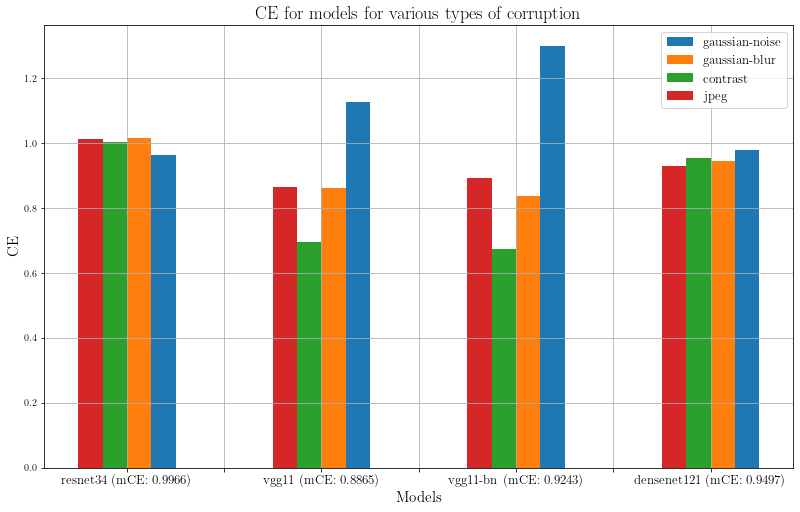

In [19]:
plot_multiple_categorical_histogram(
    [1, 3, 5, 7],
    df_ce.values.T,
    labels=list(df_ce.columns),
    xlabels=list(df_ce.index),
    title="CE for models for various types of corruption",
    xlabel="Models",
    ylabel="CE",
    width=1.0,
    figsize=(11, 7),
    filname="../results/ce_error_across_models.png"
)

In [20]:
df_rce

,gaussian_noise,gaussian_blur,contrast,jpeg
resnet34,0.922207,1.038826,1.001711,1.056632
vgg11,1.484553,1.064248,0.603454,1.31843
vgg11_bn,1.922991,1.187659,0.687306,1.895182
densenet121,1.107902,1.145135,1.100653,1.30303


In [21]:
df_rce.mean(axis=1)

resnet34       1.004844
vgg11          1.117671
vgg11_bn       1.423284
densenet121    1.164180
dtype: float64

/var/folders/nw/93_by3716yn881ckngw_vmp40000gn/T/ipykernel_36171/565391879.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(_xlabels, fontsize=13)


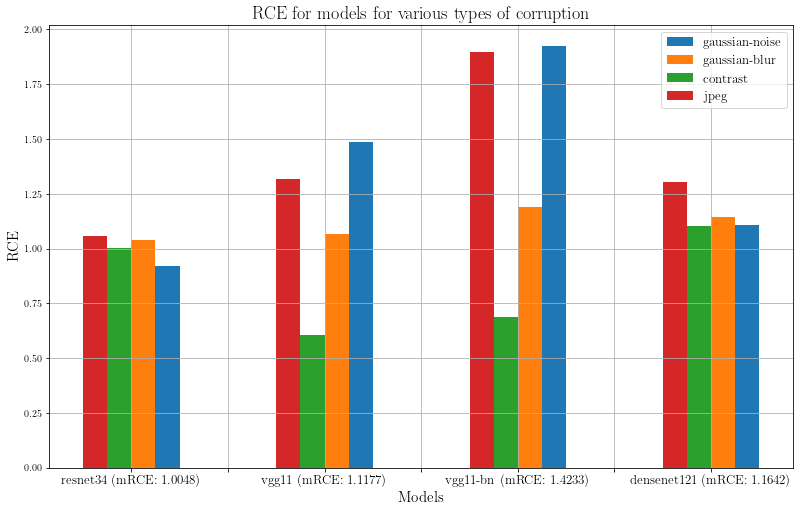

In [22]:
plot_multiple_categorical_histogram(
    [1, 3, 5, 7],
    df_rce.values.T,
    labels=list(df_rce.columns),
    xlabels=list(df_rce.index),
    title="RCE for models for various types of corruption",
    xlabel="Models",
    ylabel="RCE",
    width=1.0,
    figsize=(11, 7),
    filname="../results/rce_error_across_models.png"
)